In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.5s remaining:    4.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
 50%|█████     | 1/2 [00:00<00:00,  2.00it/s]c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
100%|██████████| 2/2 [00:00<00:00, 999.36it/s]


source data shape:  (1284, 200) (1284, 200)


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


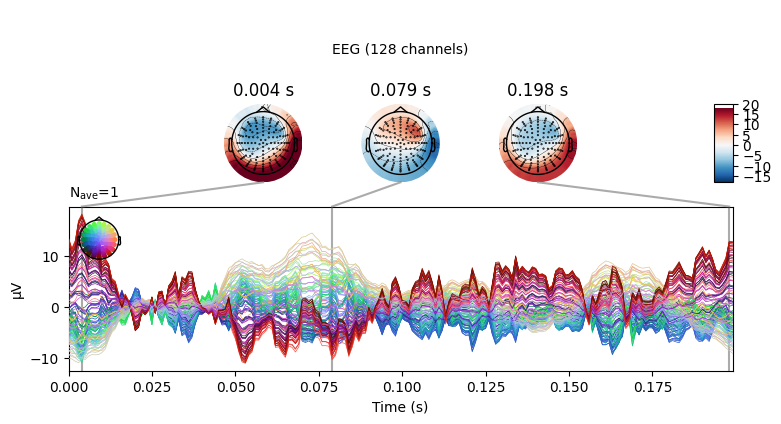

In [3]:
settings = dict(
    number_of_sources=3,
    extents=(1, 2),
    duration_of_trial=0.2,
    amplitudes=100,
    target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

c:\Users\lukas\Dokumente\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


No projector specified for this dataset. Please consider the method self.add_proj.


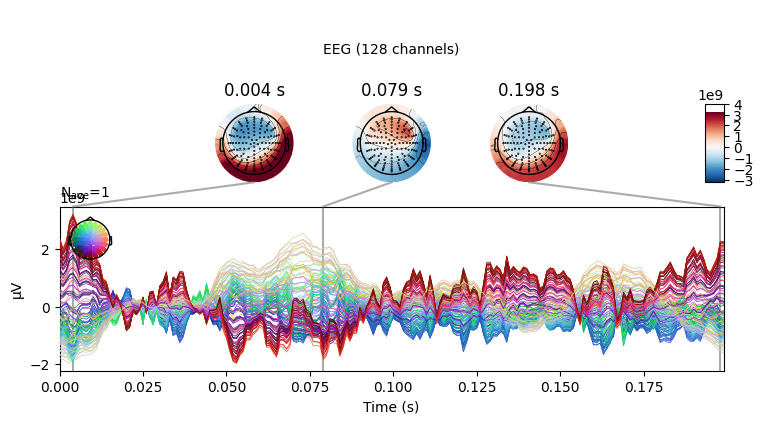

Using control points [0.34799706 0.39040923 0.85839143]
Using control points [0.         0.         0.66087294]


In [12]:
from invert import Solver
solver = Solver("smap")
solver.make_inverse_operator(fwd, evoked, alpha=0.05, max_iter=10)
stc_ = solver.apply_inverse_operator(evoked,)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


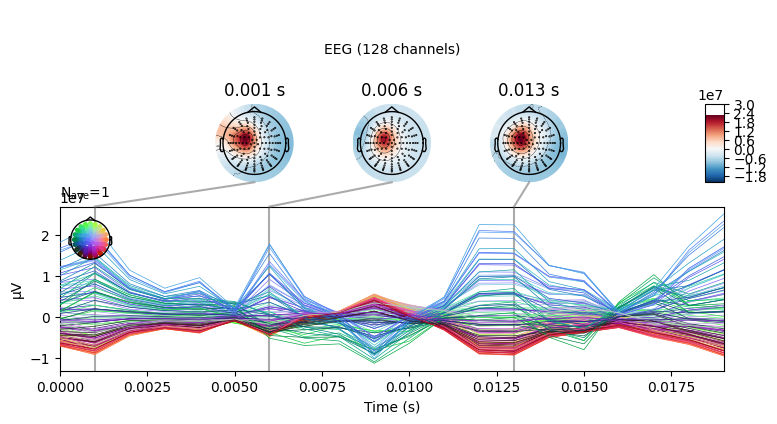

Using control points [0.13946402 0.17703655 0.83466987]


In [5]:
from invert.adapters import stampc
stc_stamp = stampc(stc_, evoked, fwd, n_orders=2, rv_thresh=0.1)
stc_stamp.data /= abs(stc_stamp.data).max()
brain = stc_stamp.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_stamp.data, info)
evoked_.plot_joint()

# Big Loop

In [7]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", #"FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", #"Backus-Gilbert", 
                "S-MAP",
                "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA", "Champagne", 
                "MVAB",
                "Fully-Connected", 
                #"LUCAS",
                "OMP", "COSAMP", "SOMP", "SP", "SSP", #"REMBO",
                "SMP", "SSMP", "SubSMP",
                "BCS", "Gamma-MAP", "Source-MAP"
            ]

redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

settings = dict(
    number_of_sources=(1, 8), 
    extents=(1, 35), 
    duration_of_trial=0.005, 
    target_snr=(2, 50))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(25)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=(2,50), extents=(1, 35)), n_simulations=10000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )
        if not solver_name + "_stampc" in errors_corr.keys():
            print("recreating")
            errors_corr[solver_name + "_stampc"] = []
            errors_mle[solver_name + "_stampc"] = []
            errors_auc[solver_name + "_stampc"] = []
            errors_nmse[solver_name + "_stampc"] = []
        try:
            stc_hat_stamp = stampc(stc_hat, evoked, fwd, n_orders=1, rv_thresh=0.1)

            error_corr = np.mean(corr(stc.data, stc_hat_stamp.data))
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat_stamp.data))
        except:
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan
        errors_corr[solver_name + "_stampc"].append( error_corr )
        errors_mle[solver_name + "_stampc"].append( error_mle )
        errors_auc[solver_name + "_stampc"].append( error_auc )
        errors_nmse[solver_name + "_stampc"].append( error_nmse )
        
        # print(error_corr, error_mle, error_auc)

    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 25/25 [00:00<00:00, 12526.29it/s]


source data shape:  (1284, 5) (1284, 5)


100%|██████████| 25/25 [00:00<00:00, 309.47it/s]


0
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


recreating
wMNE
recreating
dSPM
recreating
LORETA
recreating
sLORETA
recreating
eLORETA
recreating
LAURA
recreating
S-MAP
recreating
Multiple Sparse Priors
recreating
Bayesian LORETA
recreating
Bayesian MNE
recreating
Bayesian Beamformer
recreating
Bayesian Beamformer LORETA
recreating
Champagne
recreating
MVAB
recreating
Fully-Connected
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 10000/10000 [00:00<00:00, 29404.02it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 10000/10000 [00:12<00:00, 778.67it/s]
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\util\util.py:122: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs = [epoch.set_eeg_reference('average', projection=True, verbose=0) for epoch in epochs]
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\util\util.py:122: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs = [epoch.set_eeg_reference('average', projection=True, verbose=0) for epoch in epochs]
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\util\util.py:122: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs = [epoch.set_eeg_reference('average', projection=True, verbose=0) for epoch in epochs]
c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\util\util.py:122: RuntimeWarning: An average reference projection was already ad

preprocess data
fit model
1/1 [==============================] - 0s 64ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


recreating
OMP
recreating
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


recreating
SOMP
recreating
SP
recreating
SSP
recreating
SMP
recreating
SSMP
recreating
SubSMP
recreating
BCS
recreating
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


recreating
Source-MAP
recreating
Saving errors
1
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 26ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
2
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 17ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:88: RuntimeWarning: invalid value encountered in double_scalars
  area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5


SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
3
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 18ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
4
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: overflow encountered in double_scalars
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: invalid value encountered in multiply
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)


Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 19ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
5
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 16ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\util\util.py:88: RuntimeWarning: invalid value encountered in double_scalars
  area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5


SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
6
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 17ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
7
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
8
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
9
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 19ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
10
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 16ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
11
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
12
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: overflow encountered in double_scalars
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: invalid value encountered in multiply
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)


Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 20ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
13
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
14
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 16ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
15
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 28ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
16
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 17ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
17
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 20ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
18
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 17ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
19
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
20
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 16ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
21
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 14ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
22
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 15ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
23
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer
Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 14ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors
24
MNE


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:114: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


wMNE
dSPM
LORETA
sLORETA
eLORETA
LAURA
S-MAP
Multiple Sparse Priors
Bayesian LORETA
Bayesian MNE
Bayesian Beamformer


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: overflow encountered in double_scalars
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\empirical_bayes.py:663: RuntimeWarning: invalid value encountered in multiply
  return np.sum([np.e**x * Q for x, Q in zip(X, Q_e)], axis=0)


Bayesian Beamformer LORETA
Champagne
MVAB
Fully-Connected
1/1 [==============================] - 0s 14ms/step


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\optimize\_minimize.py:863: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


OMP
COSAMP
Projections have already been applied. Setting proj attribute to True.


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\matching_pursuit.py:263: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj()


SOMP
SP
SSP
SMP
SSMP
SubSMP
BCS
Gamma-MAP


c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\bayes.py:176: RuntimeWarning: invalid value encountered in sqrt
  term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))


Source-MAP
Saving errors


In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
for key, val in errors_mle.items():
    errors_mle[key] = val[:31]

for key, val in errors_corr.items():
    errors_mle[key] = val[:31]

for key, val in errors_auc.items():
    errors_mle[key] = val[:31]
    

# Plot

In [14]:
# df = pd.DataFrame(errors_nmse)
# df

for key, value in errors_nmse.items():
    errors_nmse[key] = [np.mean(l) for l in value]

In [12]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

# df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
df = pd.DataFrame(errors_auc)
# df = pd.DataFrame(errors_nmse)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
df_mean_var = df_mean_var.sort_values(by="Median")
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
MVAB_stampc,0.491894,0.039744,12.376693,MVAB_stampc
SP,0.499052,0.002087,239.099205,SP
SSP,0.519761,0.100106,5.192123,SSP
MVAB,0.521070,0.194209,2.683042,MVAB
SSP_stampc,0.525560,0.100696,5.219290,SSP_stampc
SP_stampc,0.553213,0.145004,3.815154,SP_stampc
Bayesian Beamformer_stampc,0.561437,0.167223,3.357416,Bayesian Beamformer_stampc
Multiple Sparse Priors_stampc,0.578739,0.155522,3.721274,Multiple Sparse Priors_stampc
LORETA_stampc,0.583129,0.161793,3.604163,LORETA_stampc
Bayesian Beamformer,0.594332,0.188636,3.150688,Bayesian Beamformer


Text(0, 0.5, 'Variance')

In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)